- Bibliothèques
- Data Loading
- Data Understanding
- Data cleaning
- Analyse du marché
- Etude de l'impact de la publicité sur les consommateurs

**Contexte**

Après avoir réalisé une campagne de publicité sur internet et à la télévision, un site ed e-commerce souhaite évaluer l'efficacité de cette campagne sur ses consommateurs.
Les objectifs sont donc de :
1) Comprendre le marché en étudiant les chiffres intéressants tels que : nombre de ventes par pays, panier moyen par acheteur, ...
2) Comprendre l'impact de la publicité sur les ventes

La société nous a donc fourni 3 dataframes suivants : 
- Uune base transactionnelle
- Une base de données d'expositions à de la publicité composée de 3 champs (un id, une date à laquelle il a vu une publicité, le canal utilisé soit Télévision soit via le web (Display) 
- Une base de mapping d'identifiants. 


# <font color='green'> Bibliothèques

In [1]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import numpy as np
from datetime import datetime
import fonctions_file as f
from sklearn.linear_model import LinearRegression


path = "./inputs/"

# <font color='green'> Data loading

In [2]:
df_impression = pd.read_csv(path + "impression.csv")
df_mapping = pd.read_csv(path + "mapping.csv")
df_transaction = pd.read_csv(path + "transaction_data.csv")

**Dataframe : `impression`** : Base de données des publicités diffusées ET visionnées.

- `ttd_id` : Identifiant de la publicité visionnée
- `impression_time` : Date de diffusion de la publicité
- `channel` : Canal de diffusion d'une publicité

In [3]:
df_impression.head()

,ttd_id,impression_time,channel
0,64698,2018-04-11,TV
1,32351,2018-06-15,TV
2,26565,2018-05-05,TV
3,36783,2018-04-01,TV
4,29526,2018-06-30,TV


**Dataframe : `mapping`** : Historique des transactions réalisées

- `UserId`: Identifiant de la personne ayant réalisé la transaction
- `TransactionId`: Identifiant de la personne ayant réalisé la transaction
- `TransactionTime`: Identifiant de la personne ayant réalisé la transaction - **Simplifier la date au format YYYY-MM-DD (comme `df_impression`)**
- `ItemCode`: Identifiant unique de l'article commandé
- `ItemDescription`: Libellé de l'article commandé
- `NumberOfItemPurchased`: Quantité commandé - **Modifier le nom de l'attribut par `ItemQuantity`**
- `CostPerItem`: Prix unitaire de l'article - **Modifier le nom de l'attribut par `ItemCost`**
- `Country`: Pays dans lequel la transaction a été réalisée

In [4]:
df_transaction.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


**Dataframe : `mapping`** : Base de données de mapping permettant de joindre les dataframes `impresion` et `transaction` via l'identifiant d'utilisateur et l'identifiant d'une publicité

- `transac_id`: Identifiant de la transaction associé au visionnage de cette publicité. FK = `TransactionId`
- `impression_id`: Identifiant de a publicité visionnée. FK = `ttd_id`

In [5]:
df_mapping.head()

,transac_id,impression_id
0,278166.0,16964
1,337701.0,3008
2,267099.0,30077
3,380478.0,75753
4,NaN,79310


# <font color='green'> Data understanding

### <font color='green'> df_impression

In [6]:
df_impression.head()

,ttd_id,impression_time,channel
0,64698,2018-04-11,TV
1,32351,2018-06-15,TV
2,26565,2018-05-05,TV
3,36783,2018-04-01,TV
4,29526,2018-06-30,TV


In [7]:
f.analyse_df(df_impression)

DATAFRAME
     Nombre de ligne: 10000000
     Nombre attributs: 3

Attribut :ttd_id
     Nombre de données : 10000000
     Nombre de données uniques: 100000
     Nombre de NaN: 0
     Type de données : int64
     Exemple de données : [64698 32351 26565 36783 29526]
     Minimum : 1
     Maximum : 100000


Attribut :impression_time
     Nombre de données : 10000000
     Nombre de données uniques: 90
     Nombre de NaN: 0
     Type de données : object
     Exemple de données : ['2018-04-11' '2018-06-15' '2018-05-05' '2018-04-01' '2018-06-30']
     Minimum : 2018-04-01
     Maximum : 2018-06-30


Attribut :channel
     Nombre de données : 10000000
     Nombre de données uniques: 2
     Nombre de NaN: 0
     Type de données : object
     Exemple de données : ['TV' 'DISPLAY']
     Minimum : DISPLAY
     Maximum : TV



**Observations**

- Il n'y a pas de NaN dans ce dataframe
- Il y a 10,000,000 de publicités visionnées associées à 100,000 transactions 
- La durée de la campagne publicitaire s'étend de 2018-04-01 au 2018-06-30 (YYYY-MM-DD) *(90 jours, cohérent avec le nombre de `impression_time` uniques)*

**NB : Attention au format de `impression_time` qui sont des objects** 


### <font color='green'> df_mapping

In [8]:
df_mapping.head()

,transac_id,impression_id
0,278166.0,16964
1,337701.0,3008
2,267099.0,30077
3,380478.0,75753
4,NaN,79310


In [9]:
f.analyse_df(df_mapping)

DATAFRAME
     Nombre de ligne: 4373
     Nombre attributs: 2

Attribut :transac_id
     Nombre de données : 4373
     Nombre de données uniques: 4372
     Nombre de NaN: 1
     Type de données : float64
     Exemple de données : [278166. 337701. 267099. 380478.     nan]
     Minimum : 259266.0
     Maximum : 384027.0


Attribut :impression_id
     Nombre de données : 4373
     Nombre de données uniques: 4276
     Nombre de NaN: 0
     Type de données : int64
     Exemple de données : [16964  3008 30077 75753 79310]
     Minimum : 28
     Maximum : 99985



**Observations**

- Présence d'1 NaN dans ce dataframe : **A supprimer**
- `transac_id` est de type float et `impression_id` est de type int64 : **Convertir transac_id en int64**
- On constate qu'il y a 4276 `impression_id` pour 4373 `transac_id`, cela signifie que certains `impression_id` sont à l'origine de plusieurs transactions, ce n'est pas une erreur. 


### <font color='green'> df_transaction

In [ ]:
df_transaction.head()

In [11]:
f.analyse_df(df_transaction)

DATAFRAME
     Nombre de ligne: 1083818
     Nombre attributs: 8

Attribut :UserId
     Nombre de données : 1083818
     Nombre de données uniques: 4373
     Nombre de NaN: 0
     Type de données : int64
     Exemple de données : [278166 337701 267099 380478     -1]
     Minimum : -1
     Maximum : 384027


Attribut :TransactionId
     Nombre de données : 1083818
     Nombre de données uniques: 25900
     Nombre de NaN: 0
     Type de données : int64
     Exemple de données : [6355745 6283376 6385599 6044973 6143225]
     Minimum : 5900015
     Maximum : 6397457


Attribut :TransactionTime
     Nombre de données : 1083818
     Nombre de données uniques: 23260
     Nombre de NaN: 0
     Type de données : object
     Exemple de données : ['Sat Feb 02 12:50:00 IST 2019' 'Wed Dec 26 09:06:00 IST 2018'
 'Fri Feb 15 09:45:00 IST 2019' 'Fri Jun 22 07:14:00 IST 2018'
 'Mon Sep 10 11:58:00 IST 2018']
     Minimum : Fri Apr 06 06:15:00 IST 2018
     Maximum : Wed Sep 26 13:29:00 IST 2018


Attri

**Observations**

`UserId`
- 4373 valeurs différentes : C'est cohérent avec `transac_id`. On en déduit que `transac_id` est la clé étrangère de `UserId` : **Renommer `transac_id` par `UserId_FK`
- On a une valeur égale à -1 : **Ne pas prendre en compte cette donnée**

`TransactionId`
- A première vue, il ne semble pas y avoir de données corrompues

`TransactionTime`
- Les dates ne sont pas au format date : les valeurs min et max renvoyées ne sont donc pas bonnes. : **Convertir `TransactionTime` au type date YYYY-MM-DD
- Supprimer les dates dans le futur

`ItemCode`
- 3407 références uniques
- Une référence est à -1 : **Ne pas prendre en compte cette donnée**

`ItemDescription`
- 4223 données uniques : pas cohérent avec le nombre `ItemCode` : **Nous traiterons les items selon leur `Item` et non leur `ItemDescription`
- 2908 NaN : **Pas d'importance car les items sont génés par `ItemCode`

`NumberOfItemsPurchased`
- Présence de valeurs négatives : **Ne pas prendre en compte ces données**
- Présence de valeurs aberrantes : 242985. Nous prendrons la décision de ne pas traiter les transactions avec `NumberOfItemsPurchased` au-delà d'un certain seuil qui sera déterminé plus tard

`CostPerItem`
- Présence de valeurs négatives : **Ne pas prendre en compte ces données**
- Présence de valeurs aberrantes : 1696285. Nous prendrons la décision de ne pas traiter les transactions avec `CostPerItem` au-delà d'un certain seuil qui sera déterminé plus tard

`Country`
- A première vue, il ne semble pas y avoir de données corrompues

# <font color='green'> Data cleaning

**En se basant sur ce qui a été observé sur les dataframes, voici les actions à réaliser :**

`df_impression`
- Modifier le format de `impression_time` en type date
- Renommer `impression_time` en `ImpressionDate`
- Renommer `ttd_id` en `ImpressionId_FK`
- S'assurer de suppimer les doublons

`df_mapping`
- Supprimer 1 NaN
- Convertir `transac_id` en type int64
- Renommer `transac_id` en `UserId_FK`
- S'assurer de suppimer les doublons

`df_transaction`
- Supprimer 1 NaN `UserId`
- Convertir `TransactionTime` au type date YYYY-MM-DD
- Supprimer un `ItemCode` à -1
- Supprimer les valeurs négatives de `NumberOfItemsPurchased`
- Supprimer les valeurs aberrantes de `NumberOfItemsPurchased` (définir le seuil)
- Renommer `NumberOfItemsPurchased` en `Quantity`
- Supprimer les valeurs négatives de `CostPerItem`
- Supprimer les valeurs aberrantes de `CostPerItem` (définir le seuil)
- Renommer `CostPerItem` en `ItemCost`
- S'assurer de suppimer les doublons

In [14]:
#Nettoyage de df_transaction_clean
q="""
SELECT
    UserId,
    TransactionId,
    TransactionTime AS TransactionDate,
    (NumberOfItemsPurchased * CostPerItem) AS TransactionCost,
    ItemCode AS ItemId,
    ItemDescription,
    NumberOfItemsPurchased AS Quantity,
    CostPerItem AS ItemCost,
    Country
FROM df_transaction
WHERE 
    UserId > 0
    AND ItemId > 0
    AND Quantity > 0
    AND ItemCost > 0
"""
df_transaction_clean =sqldf(q)

#On convertit TransactionDate au format YYYY-MM-DD
df_transaction_clean['TransactionDate']= pd.to_datetime(df_transaction_clean['TransactionDate'])
df_transaction_clean['TransactionDate'] = df_transaction_clean['TransactionDate'].dt.date

#On supprime les dates erronées
df_transaction_clean['TransactionDate'] = pd.to_datetime(df_transaction_clean['TransactionDate'])
df_transaction_clean = df_transaction_clean[df_transaction_clean['TransactionDate'] <= pd.Timestamp('2020-01-01')]


#On retire les NaN du dataframe
df_transaction_clean = df_transaction_clean.dropna()

#On supprime les doublons
df_transaction_clean = df_transaction_clean.drop_duplicates()

#On ne retient pas les valeurs aberrantes pour Quantity et ItemCost
df_transaction_clean = f.filter_aberrant_values(df_transaction_clean, 'Quantity')
df_transaction_clean = f.filter_aberrant_values(df_transaction_clean, 'ItemCost')

#enregistrement
df_transaction_clean.to_csv('./dataframes_saved/df_transaction_clean.csv', index=False)

C:\Users\poljo\anaconda3\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [16]:
#Nettoyage de df_impression
q="""
SELECT
    ttd_id AS ImpressionId_PK,
    impression_time AS ImpressionDate,
    channel AS Channel
FROM df_impression
"""
df_impression_clean =sqldf(q)

#On supprime les doublons
df_impression_clean = df_impression_clean.drop_duplicates()

#enregistrement
df_impression_clean.to_csv('./dataframes_saved/df_impression_clean.csv', index=False)

In [18]:
#Nettoyage de df_mapping
q="""
SELECT
 transac_id AS UserId_FK,
 impression_id AS ImpressionId_FK
FROM df_mapping
"""
df_mapping_clean =sqldf(q)

#On retire les NaN du dtaframe
df_mapping_clean = df_mapping_clean.dropna()

#On supprime les doublons
df_mapping_clean = df_mapping_clean.drop_duplicates()

#On modifie le type de UserId_FK en Int
df_mapping_clean['UserId_FK'] = df_mapping_clean['UserId_FK'].astype(int)

#enregistrement
df_mapping_clean.to_csv('./dataframes_saved/df_mapping_clean.csv', index=False)

# <font color='green'> Analyse du marché

In [19]:
df_transaction_clean = pd.read_csv("./dataframes_saved/df_transaction_clean.csv")
df_transaction_clean.head()

,UserId,TransactionId,TransactionDate,TransactionCost,ItemId,ItemDescription,Quantity,ItemCost,Country
0,278166,6355745,2019-02-02,70.38,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,267099,6385599,2019-02-15,64.80,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
2,285957,6307136,2019-01-11,42.24,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom
3,345954,6162981,2018-09-28,61.56,471576,NATURAL SLATE CHALKBOARD LARGE,9,6.84,United Kingdom
4,339822,6255403,2018-12-10,42.48,1783845,MULTI COLOUR SILVER T-LIGHT HOLDER,36,1.18,United Kingdom


### <font color='green'> Analyse par pays

Nous allons commencer par analyser le dataframe `df_transaction_clean` en fonction de l'attibut `Country`. 

Dans un premier temps, nous allons nous intéresser aux transactions qui ont été réalisées. Nous allons pour cela discriminer les transactions en fonction du pays dans lequel, chaque transaction a été réalisée.

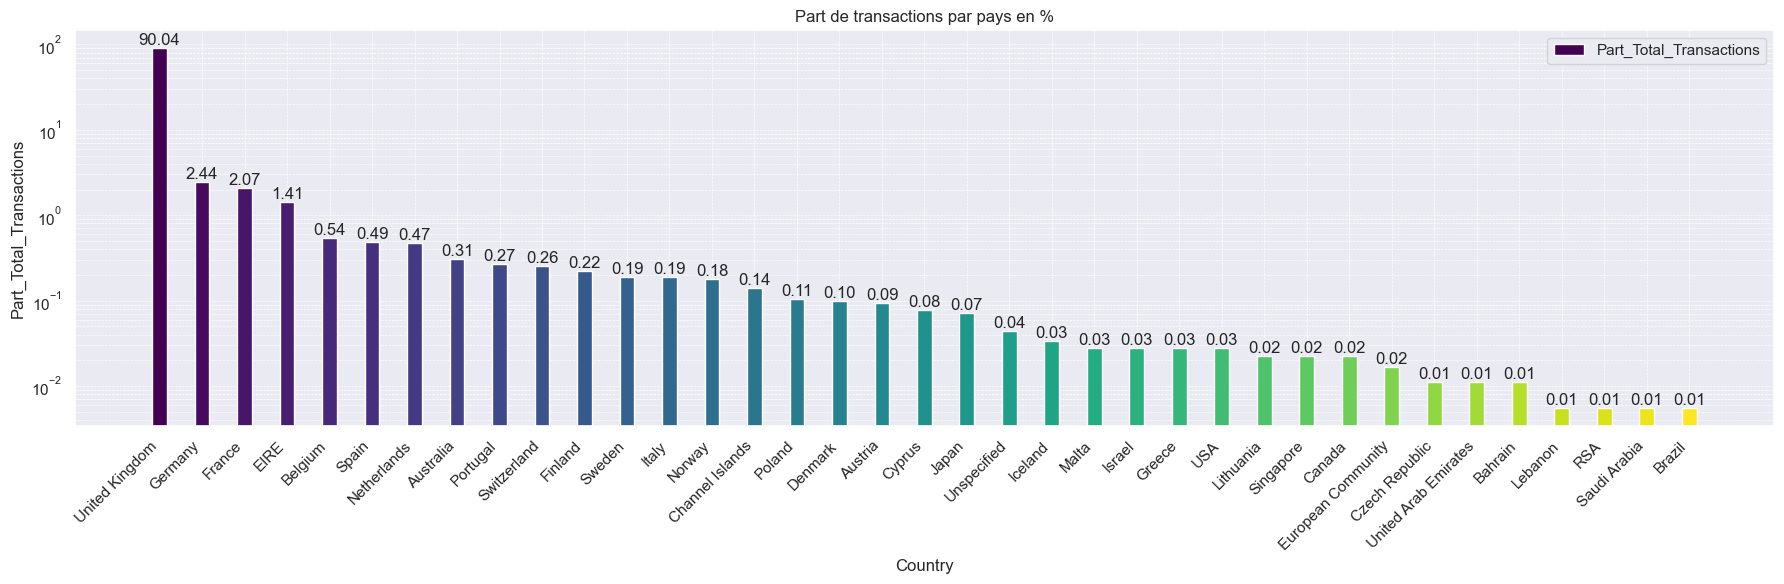

In [20]:
q="""
SELECT
    Country,
    COUNT(DISTINCT TransactionId) AS Nbr_Transaction
FROM df_transaction_clean
GROUP BY Country
"""
df_nbr_transaction_per_country = sqldf(q)

df_nbr_transaction_per_country['Part_Total_Transactions']=df_nbr_transaction_per_country['Nbr_Transaction']/df_transaction_clean['TransactionId'].nunique()*100

#On trie par ordre décroissant
df_nbr_transaction_per_country = df_nbr_transaction_per_country.sort_values('Part_Total_Transactions', ascending = False)

f.histogramme_baton(df_nbr_transaction_per_country, 'Country', 'Part_Total_Transactions', 'Part de transactions par pays en %',2)

On constate que la majeure partie des transactions sont générées par un seul pays : United Kingdom. A lui seul, le pays représente 90% des transactions qui ont été réalisées sur la période étudiée.

Il serait d'étudier le nombre de `UserId` uniques par pays afin de savoir si cette domination de UK en termes de en termes de `Nbr_transaction` s'explique par une sur-rerprésentation des consommateurs UK par rapport au consommateurs dans les autres pays.

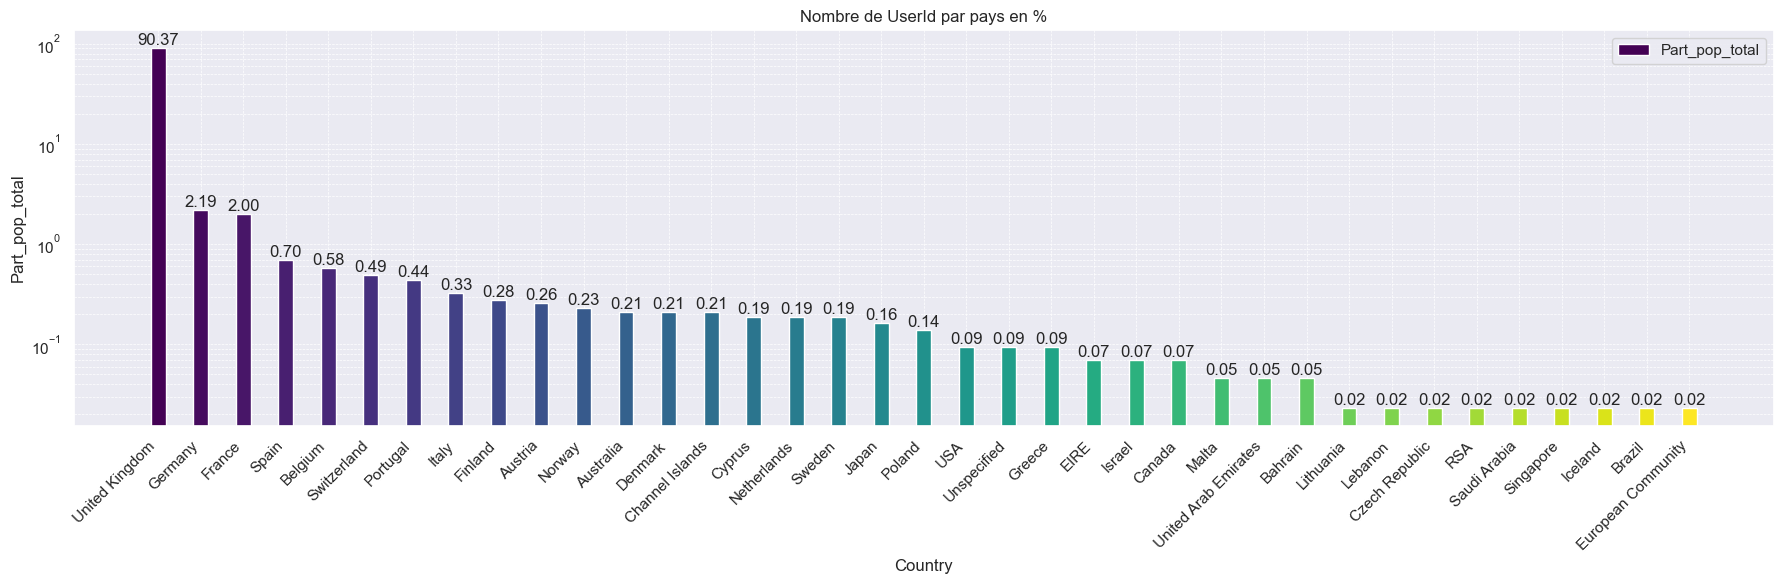

In [21]:
q="""
SELECT
    Country,
    COUNT(DISTINCT UserId) AS Nbr_user
FROM df_transaction_clean
GROUP BY Country
"""
df_Nbr_user_per_country = sqldf(q)
df_Nbr_user_per_country['Part_pop_total'] = df_Nbr_user_per_country['Nbr_user'] / df_transaction_clean['UserId'].nunique()*100

#On trie par ordre décroissant sur Nbr_user
df_Nbr_user_per_country = df_Nbr_user_per_country.sort_values('Part_pop_total', ascending = False) 
f.histogramme_baton(df_Nbr_user_per_country, 'Country', 'Part_pop_total', 'Nombre de UserId par pays en %',2)

Effectivement, observe que 90% des consommateurs (`UserId` uniques) proviennent de UK ce qui explique cette écrasante domination en terme de `Nbr_transactions`.

Intéressons-nous à présent aux parts de marché que représentent chaque pays en termes de revenues, c'est-à-dire la somme des `TransactionCost` par pays par rapport à la somme totale des `TransactionCost`.

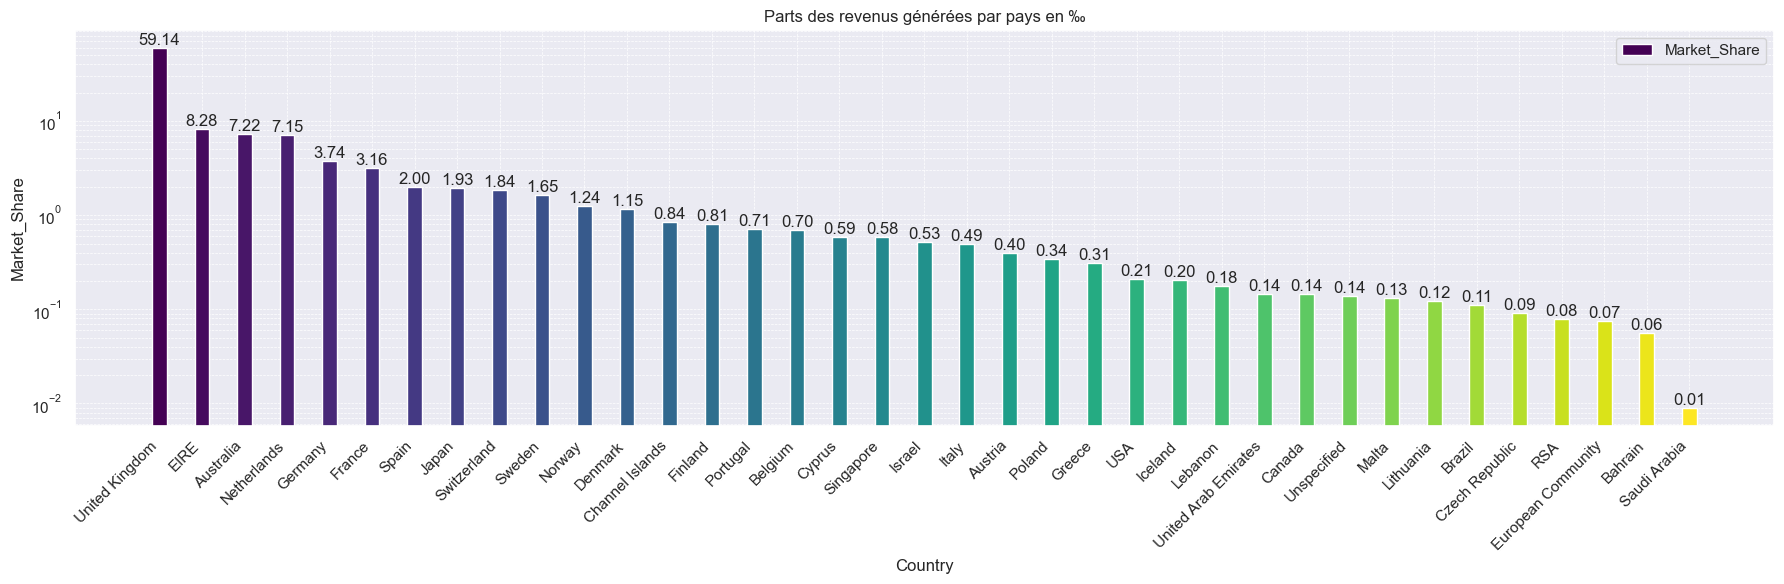

In [22]:
q="""
SELECT
    Country,
    SUM(DISTINCT TransactionCost) AS Revenues
FROM df_transaction_clean
GROUP BY Country
"""
df_revenus_per_country = sqldf(q)

#On trie par ordre décroissant
df_revenus_per_country = df_revenus_per_country.sort_values('Revenues', ascending = False) 
#On ajoute un attribut Market_Share
df_revenus_per_country['Market_Share'] = round(df_revenus_per_country['Revenues']/df_transaction_clean['TransactionCost'].sum()*1000, 3)

f.histogramme_baton(df_revenus_per_country, 'Country', 'Market_Share', 'Parts des revenus générées par pays en ‰', 2)

On constate que UK est toujours loin devant au niveau de cet indicateur mais ne représente que 6% du marché total alors que le pays représentent 90% des consommateurs. On peut donc affirmer que les consommateurs britaniques ne sont pas les plus dépensiers.

In [23]:
ranking_per_transaction = {
    'Ranking_Transaction': list(range(1, df_nbr_transaction_per_country['Country'].nunique() + 1)),
    'Country': df_nbr_transaction_per_country['Country'].tolist()
}

df_ranking_per_transaction = pd.DataFrame(ranking_per_transaction)


ranking_per_revenues = {
    'Ranking_Revenues': list(range(1, df_revenus_per_country['Country'].nunique() + 1)),
    'Country': df_revenus_per_country['Country'].tolist()
}

df_ranking_per_revenues = pd.DataFrame(ranking_per_revenues)

#Jointure des ranking
q="""
SELECT DISTINCT t.Country, t.Ranking_Transaction, r.Ranking_Revenues
FROM df_ranking_per_transaction t
LEFT OUTER JOIN df_ranking_per_revenues r ON t.Country = r.Country
"""
df_ranking = sqldf(q)


q="""
SELECT 
    *,
    (Ranking_Transaction - Ranking_Revenues) AS Difference
FROM df_ranking
"""
df_ranking = sqldf(q)
top_3_declassement = df_ranking.sort_values('Difference', ascending = True)[:4]
print('Top 3 des déclassements :\n', top_3_declassement)

top_3_surclassement = df_ranking.sort_values('Difference', ascending = False)[:3]
print('Top 3 des surclassements :\n', top_3_surclassement)

Top 3 des déclassements :
         Country  Ranking_Transaction  Ranking_Revenues  Difference
4       Belgium                    5                16         -11
20  Unspecified                   21                29          -8
22        Malta                   23                30          -7
12        Italy                   13                20          -7
Top 3 des surclassements :
       Country  Ranking_Transaction  Ranking_Revenues  Difference
19      Japan                   20                 8          12
27  Singapore                   28                18          10
33    Lebanon                   34                26           8


Il y a bien des différences entre le classement par transaction et le classement par revenues. 
On peut notamment citer les pays ayant subit les déclassements les plus importants : Belgium (-11), Malta (-7) et Italy(-7) (Nous ne considérons pas Unspecified).
A contrario, les pays ayant subi les meilleurs surclassements sont :  Japan (+12), Singapore (+10), Labenon(+8)

Ces observations quant aux classement par `Nbr_transaction` et `Revenues`, s'expliquent par 2 facteurs :

1 - Les paniers moyens ne sont pas les mêmes d'un pays à un autre

2 - Les consommateurs de certains pays ont peut-être des tendances à réaliser de nombreuses transactions

Nous allons nous intéresser à ces deux indicateurs.

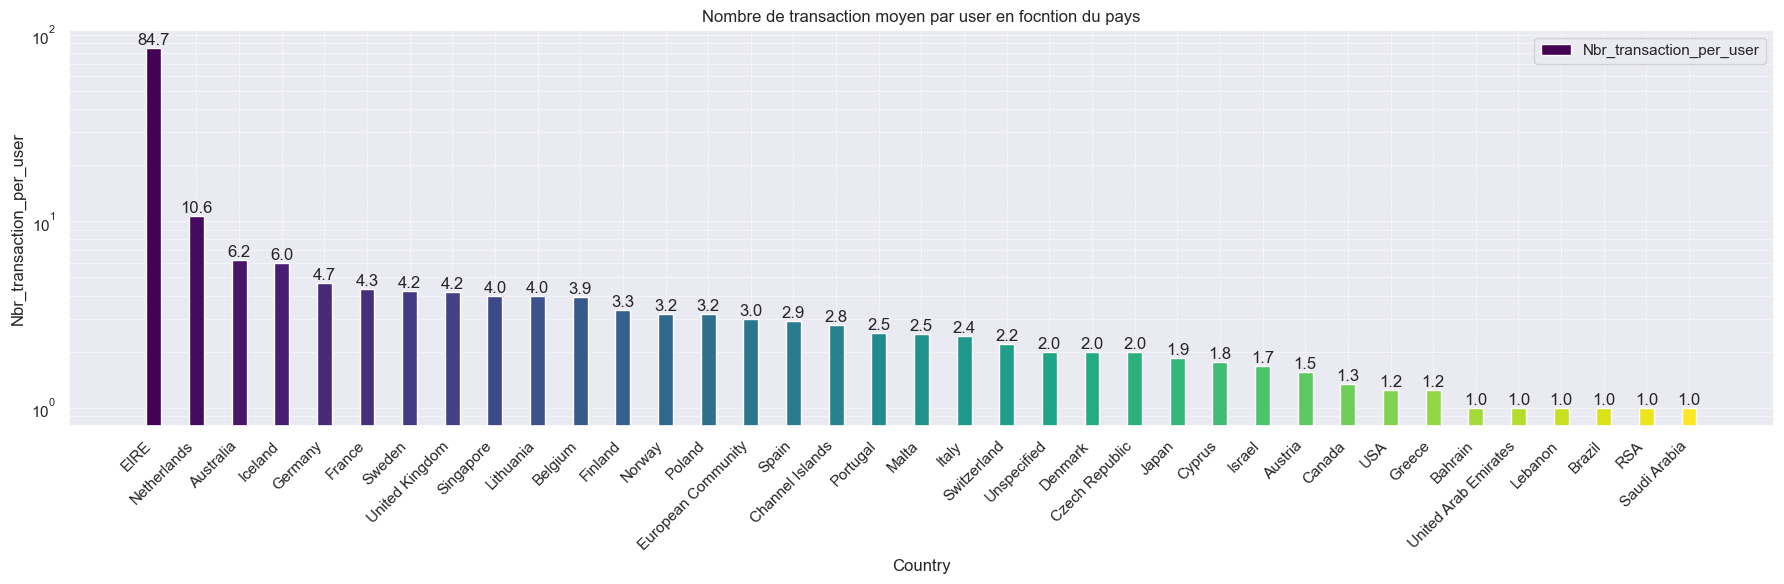

In [24]:
q="""
SELECT
    Country,
    COUNT(DISTINCT UserId) AS Nbr_user,
    COUNT(DISTINCT TransactionId) AS Nbr_transaction
FROM df_transaction_clean
GROUP BY Country
"""
df_Nbr_transaction_per_user_per_country = sqldf(q)

df_Nbr_transaction_per_user_per_country['Nbr_transaction_per_user'] = df_Nbr_transaction_per_user_per_country['Nbr_transaction'] / df_Nbr_transaction_per_user_per_country['Nbr_user']

#On trie par ordre décroissant sur Nbr_transaction_per_user
df_Nbr_transaction_per_user_per_country = df_Nbr_transaction_per_user_per_country.sort_values('Nbr_transaction_per_user', ascending = False) 
f.histogramme_baton(df_Nbr_transaction_per_user_per_country, 'Country', 'Nbr_transaction_per_user', 'Nombre de transaction moyen par user en focntion du pays',1)

On constate que EIRE se détache très largement des autres pays en termes de nombre moyen de transaction par user. En effet, en moyenne, un user en EIRE a réalisé 84.7 transaction. C'est 8x plus que le pays qui se classe 2e: Netherlands (10.6 transactions par user).

**Attention : certains pays ont très peu de transaction et/ou de user associés, les statistiques associées ne sont donc pas à prendre avec précaution**

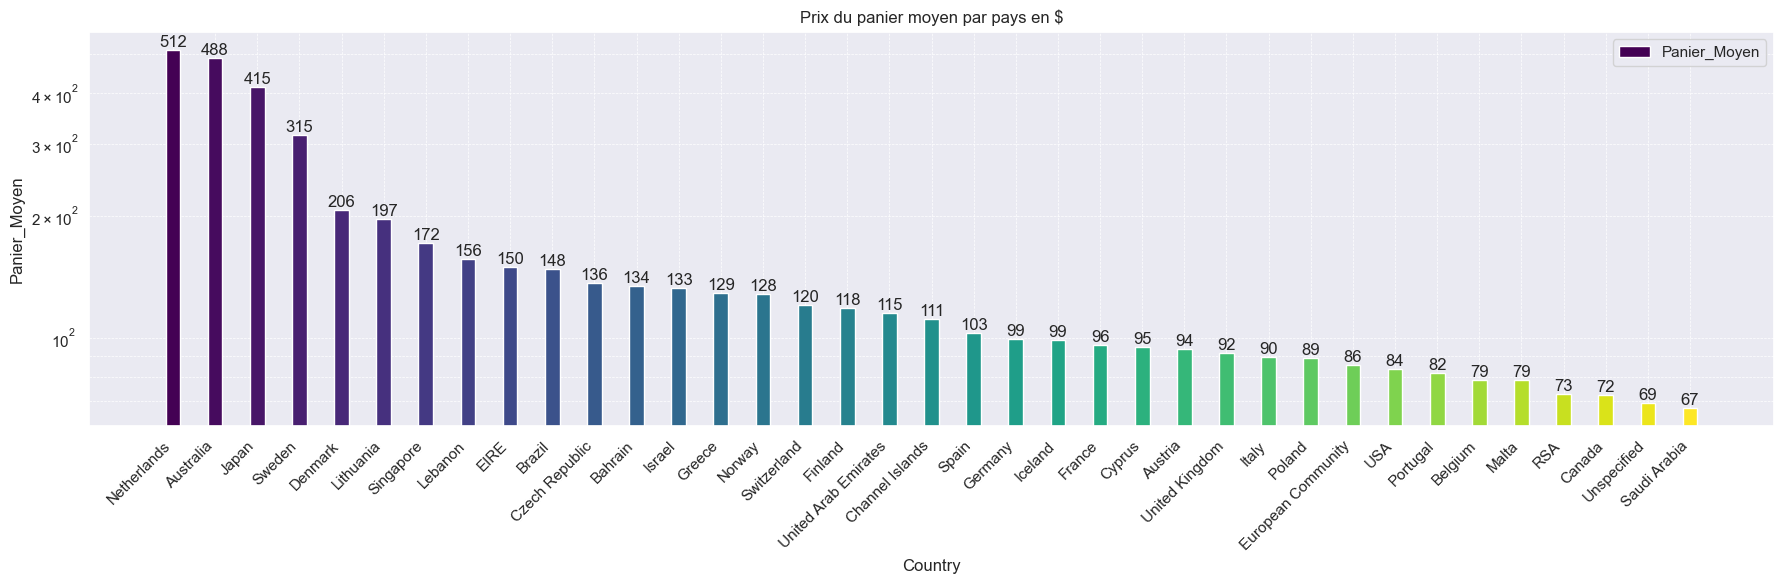

In [25]:
q="""
SELECT
    Country,
    AVG(TransactionCost) AS Panier_Moyen
FROM df_transaction_clean
GROUP BY Country
"""
df_panier_moyen_per_country = sqldf(q)

#On trie par ordre décroissant
df_panier_moyen_per_country = df_panier_moyen_per_country.sort_values('Panier_Moyen', ascending = False) 

f.histogramme_baton(df_panier_moyen_per_country, 'Country', 'Panier_Moyen', 'Prix du panier moyen par pays en $',0)

Ici, on constate que les consommateurs de Netherlands réalisent en moyenne les transactions les plus chères. 

Associé au fait que les consommateurs neerlandais sont 2e de l'indicateur du nombre de transaction par user, explique que, malgré une part de 0.19% de la population totale de `UserId`, le pays se classe 4e en termes de revenus total.

### <font color='green'> Analyse au cours du temps

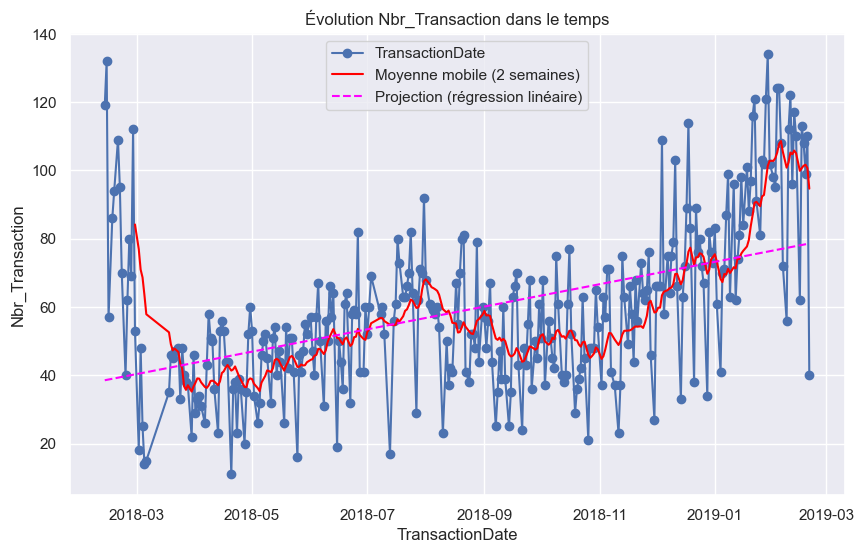

In [26]:
q="""
SELECT 
    TransactionDate,
    TransactionId,
    COUNT(DISTINCT TransactionId) AS Nbr_Transaction
FROM df_transaction_clean
GROUP BY TransactionDate
"""
df_transaction_per_date = sqldf(q)

# Conversion des dates
df_transaction_per_date['TransactionDate'] = pd.to_datetime(df_transaction_per_date['TransactionDate'])

# Trier les données par date
df_transaction_per_date = df_transaction_per_date.sort_values('TransactionDate')

#On affiche la courbe d'évolution au cours du temps
f.plot_linear_regression (df_transaction_per_date, 'TransactionDate', 'Nbr_Transaction')

Sur la courbe ci-dessus, nous pouvons observer, le nombre de transactions réalisées par jour tout au long de la période de notre étude.
La régression linéaire du nombre de transactions par jour nous montre une tendance d'augmentation du nombre de transactions par jour. Passant de 40 transactions en moyenne au début de la période à près de 80 à la fin de la période. 

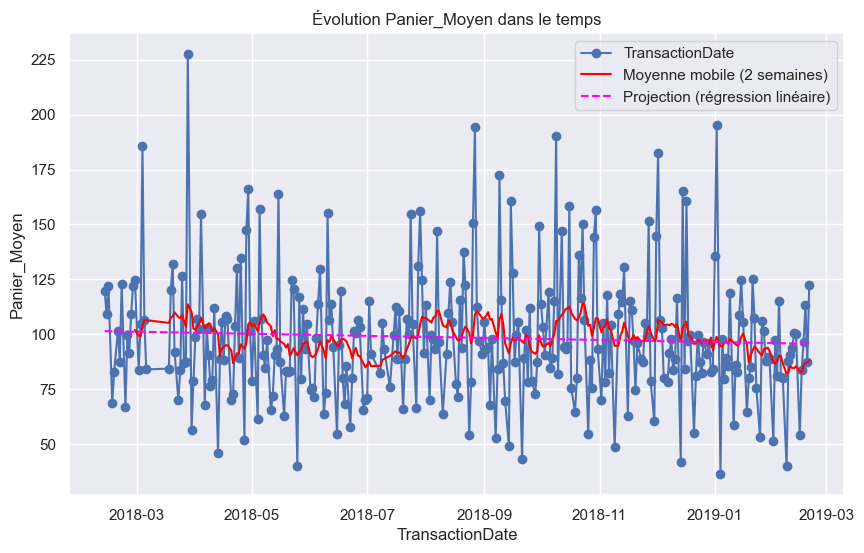

In [27]:
q="""
SELECT 
    TransactionDate,
    AVG(TransactionCost) AS Panier_Moyen
FROM df_transaction_clean
GROUP BY TransactionDate
"""
df_panier_moyen_per_date = sqldf(q)

# Conversion des dates
df_panier_moyen_per_date['TransactionDate'] = pd.to_datetime(df_panier_moyen_per_date['TransactionDate'])

# Trier les données par date
df_panier_moyen_per_date = df_panier_moyen_per_date.sort_values('TransactionDate')

#On affiche la courbe d'évolution au cours du temps
f.plot_linear_regression (df_panier_moyen_per_date, 'TransactionDate', 'Panier_Moyen')

Concernant le prix de panier moyen, on constate que la moyenne sur 2 semaine a tendance à fluctuer autour de 100$ par transaction. Même si la régression linéaire illustre une légère baisse, celle-ci semble négligeable en comparaison à l'augmentation du nombre de transactions par jours. Ainsi, les consommateurs ont eu tendance à réaliser des transactions de moins en moins couteuse au cours de la période étudiée.

A présent, si on combine ces 2 indicateurs dans un unique (l'évolution des revenus au cours du temps), on devrait observer une tendance à l'augmentation des revenus :

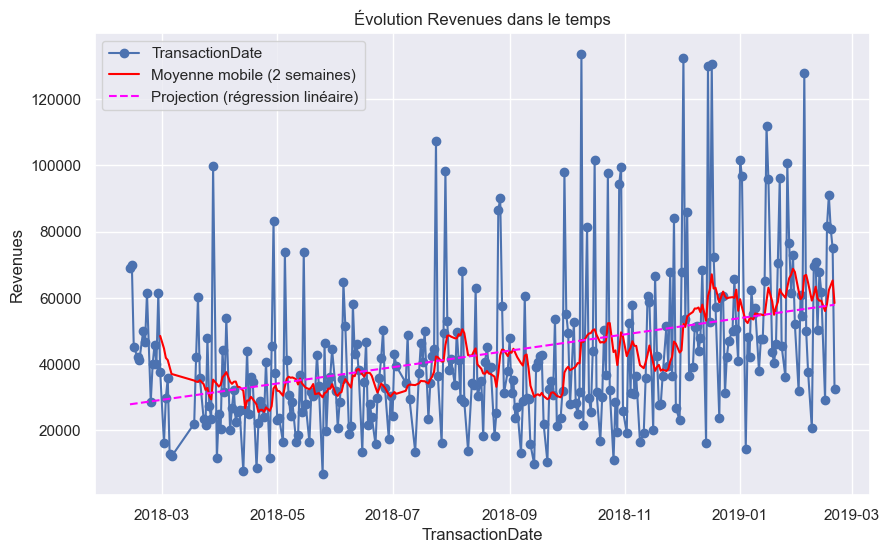

In [28]:
q="""
SELECT 
    TransactionDate,
    SUM(DISTINCT TransactionCost) AS Revenues
FROM df_transaction_clean
GROUP BY TransactionDate
"""
df_revenues_per_date = sqldf(q)

# Conversion des dates
df_revenues_per_date['TransactionDate'] = pd.to_datetime(df_revenues_per_date['TransactionDate'])

# Trier les données par date
df_revenues_per_date = df_revenues_per_date.sort_values('TransactionDate')

#On affiche la courbe d'évolution au cours du temps
f.plot_linear_regression (df_revenues_per_date, 'TransactionDate', 'Revenues')

Comme nous l'avions prédit, nous constatons une projections des revenues générés à la hausse passant de 28000 environ à presque 60000 par jour. 
Il semblerait donc que la campagne publicitaire qui a été menée a eu une réelle efficacité sur le chiffre d'affaire généré !

Nous pourrions donc nous intéresser à présent plus précisément comment la campagne publicitaire a été menée et l'impact qu'elle a eu sur les consommateurs.

### <font color='green'> Etude sur les produits

In [29]:
df_transaction_clean.head()

,UserId,TransactionId,TransactionDate,TransactionCost,ItemId,ItemDescription,Quantity,ItemCost,Country
0,278166,6355745,2019-02-02,70.38,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,267099,6385599,2019-02-15,64.80,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
2,285957,6307136,2019-01-11,42.24,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom
3,345954,6162981,2018-09-28,61.56,471576,NATURAL SLATE CHALKBOARD LARGE,9,6.84,United Kingdom
4,339822,6255403,2018-12-10,42.48,1783845,MULTI COLOUR SILVER T-LIGHT HOLDER,36,1.18,United Kingdom


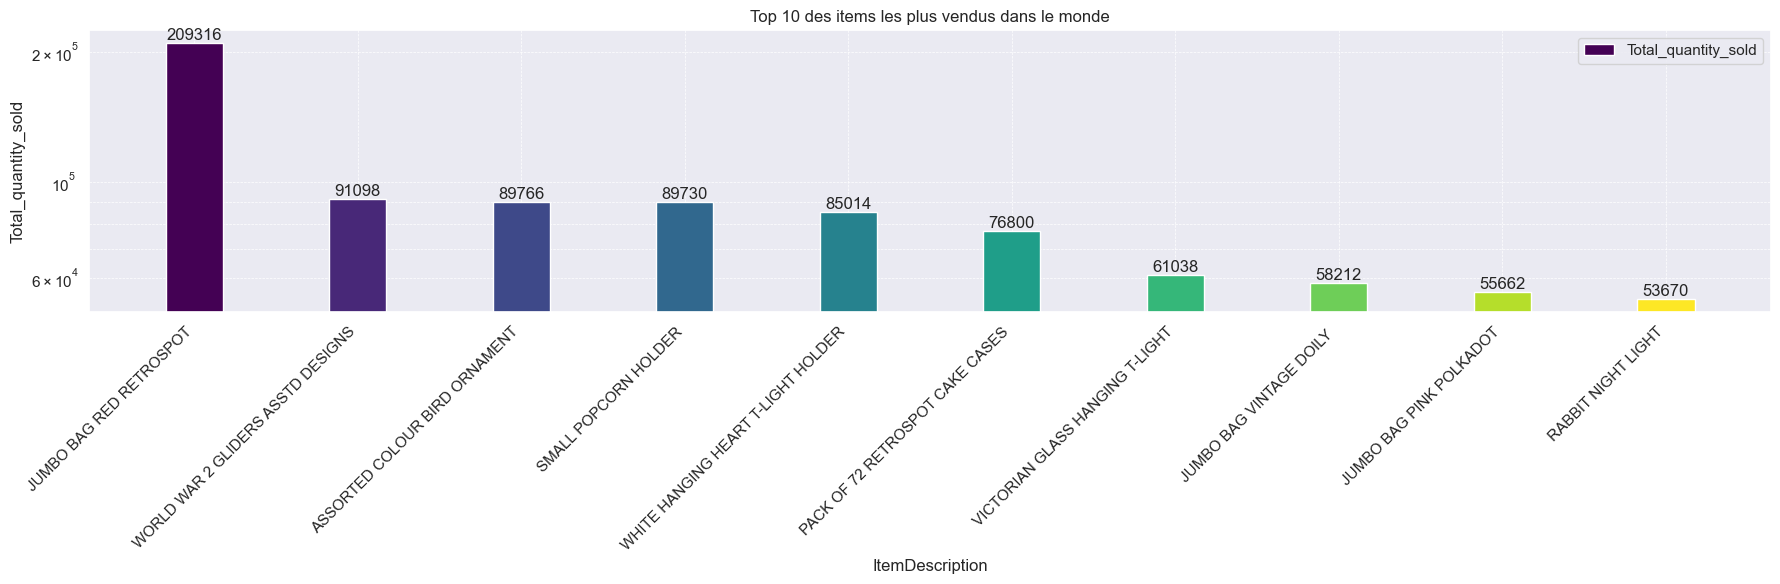

In [33]:
#Top 10 des produits les plus vendus
q="""
SELECT 
    ItemId,
    ItemDescription,
    SUM(Quantity) AS Total_quantity_sold
FROM df_transaction_clean
GROUP BY ItemId
"""
df_nbr_sales_per_item = sqldf(q)

# Trier les données par Nbr_Of_Diffussion
df_nbr_sales_per_item = df_nbr_sales_per_item.sort_values('Total_quantity_sold', ascending =False)

#On retient que les 10 premières valeurs
df_graphique = df_nbr_sales_per_item[:10]

f.histogramme_baton (df_graphique, 'ItemDescription', 'Total_quantity_sold','Top 10 des items les plus vendus dans le monde',0)

Nous allons maintenant, nous intéresser aux produit qui sont le plus souvent achetés. Car l'indicateur ci-dessus, nous donne quels ont été les produits les plus vendus mais pas le plus souvent.

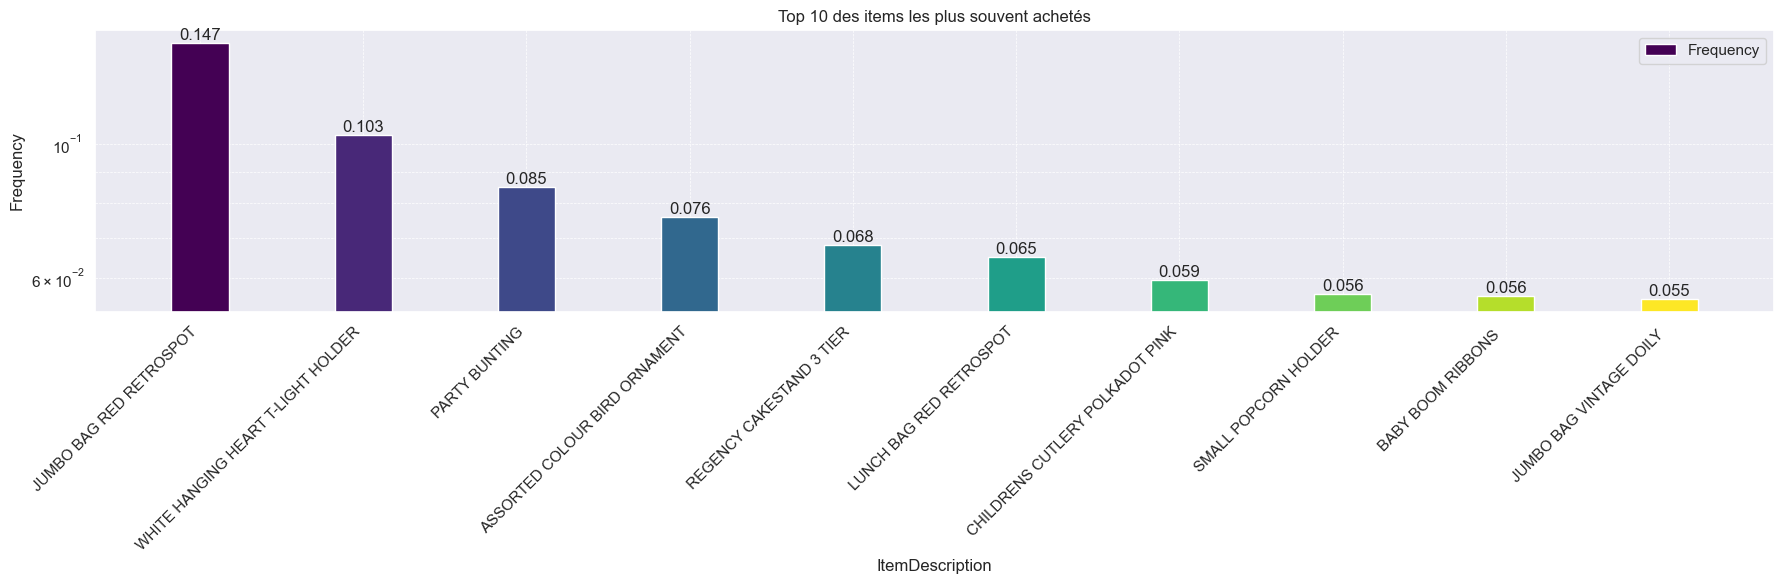

In [34]:
#Top 10 des produits les plus SOUVENT vendus
q="""
SELECT 
    ItemId,
    ItemDescription,
    COUNT(Quantity) AS Times_Sold
FROM df_transaction_clean
GROUP BY ItemId
"""
df_graphique = sqldf(q)

# Trier les données par Nbr_Of_Diffussion
df_graphique = df_graphique.sort_values('Times_Sold', ascending =False)

#On retient que les 10 premières valeurs
df_graphique['Frequency'] = df_graphique['Times_Sold']/df_transaction_clean['TransactionId'].nunique()

#On retient que les 10 premières valeurs
df_graphique =df_graphique[:10]

f.histogramme_baton (df_graphique, 'ItemDescription', 'Frequency','Top 10 des items les plus souvent achetés',3)

# <font color='green'> Etude de l'impact de la publicité sur les consommateurs

### <font color='green'> Analyse sur les impressions

In [35]:
#Chargement du dataframe
df_impression_clean = pd.read_csv("./dataframes_saved/df_impression_clean.csv")
df_impression_clean.head()

,ImpressionId_PK,ImpressionDate,Channel
0,64698,2018-04-11,TV
1,32351,2018-06-15,TV
2,26565,2018-05-05,TV
3,36783,2018-04-01,TV
4,29526,2018-06-30,TV


In [45]:
nbr_TV_impression = df_impression_clean[df_impression_clean['Channel']=='TV'].shape[0]
nbr_DISPLAY_impression = df_impression_clean[df_impression_clean['Channel']=='DISPLAY'].shape[0]

print('Part de TV impression :', round(nbr_TV_impression/(nbr_TV_impression+nbr_DISPLAY_impression)*100,2))
print('Part de DISPLAY impression :', round(nbr_DISPLAY_impression/(nbr_TV_impression+nbr_DISPLAY_impression)*100,2))

print('Nombre de Impression_PK uniques :', df_impression_clean['ImpressionId_PK'].nunique())

Part de TV impression : 50.0
Part de DISPLAY impression : 50.0
Nombre de Impression_PK uniques : 100000


Il y a autant de publicité qui ont été diffusées via TV que via DISPLAY

In [38]:
q="""
SELECT 
    ImpressionId_PK,
    COUNT(ImpressionDate) AS Nbr_of_diffusion
FROM df_impression_clean
GROUP BY ImpressionId_PK
"""
df_nbr_diffusion_per_impression = sqldf(q)

# Trier les données par Nbr_of_diffusion
df_nbr_diffusion_per_impression = df_nbr_diffusion_per_impression.sort_values('Nbr_of_diffusion')


print('Nombre de diffusion moyen par publicité :', df_nbr_diffusion_per_impression['Nbr_of_diffusion'].mean())
print('Nombre minimum de diffusion pour une publicité:', df_nbr_diffusion_per_impression['Nbr_of_diffusion'].min())
print('Nombre maximum de diffusion pour une publicité:', df_nbr_diffusion_per_impression['Nbr_of_diffusion'].max())
df_nbr_diffusion_per_impression['Nbr_of_diffusion'].describe()

Nombre de diffusion moyen par publicité : 76.71042
Nombre minimum de diffusion pour une publicité: 49
Nombre maximum de diffusion pour une publicité: 107


count    100000.000000
mean         76.710420
std           6.624656
min          49.000000
25%          72.000000
50%          77.000000
75%          81.000000
max         107.000000
Name: Nbr_of_diffusion, dtype: float64

Effectivement, on constate donc qu'une publicité est diffusée en moyenne 77 fois. La publicité ayant été la moins diffusée la été 49 fois et la plus diffusée 107 fois.



A présent, nous allons nous intéresser à l'impact de la publicité sur les transactions qui ont été réalisée. Pour cela, nous allons réaliser une jointure entre les dataframes `df_trasnaction_clean` et `df_impression_clean` en passant par `df_mapping_clean` pour créer ces liens.

**Attention, il ne faudra pas prendre en compte les transactions qui ont été réalisées avant une impression**

### <font color='green'> Jointure des dataframes

In [39]:
#Chargement des dataframes
df_transaction_clean = pd.read_csv("./dataframes_saved/df_transaction_clean.csv")
df_mapping_clean = pd.read_csv("./dataframes_saved/df_mapping_clean.csv")
df_impression_clean = pd.read_csv("./dataframes_saved/df_impression_clean.csv")

In [40]:
#Jointure de df_transaction_clean et df_mapping_clean
#On passe par une commande python pour que l'exécution se fasse plus rapidement
df_join_transaction_mapping = pd.merge(df_transaction_clean, df_mapping_clean, left_on='UserId', right_on='UserId_FK', how='left')

#On joint à présent df_join_transaction_mapping avec df_impression_clean
df_join_transaction_impression_clean = pd.merge(df_join_transaction_mapping, df_impression_clean, left_on='ImpressionId_FK', right_on='ImpressionId_PK', how='outer')

#On supprime les NaN
df_join_transaction_impression_clean = df_join_transaction_impression_clean.dropna()

#On ne doit pas prendre en compte les lignes où ImpressionDate est postérieur à TransactionDate
# Conversion des dates
df_join_transaction_impression_clean['ImpressionDate'] = pd.to_datetime(df_join_transaction_impression_clean['ImpressionDate'])
df_join_transaction_impression_clean['TransactionDate'] = pd.to_datetime(df_join_transaction_impression_clean['TransactionDate'])

#Filtre des lignes
df_join_transaction_impression_clean = df_join_transaction_impression_clean[df_join_transaction_impression_clean['ImpressionDate']<df_join_transaction_impression_clean['TransactionDate']]

#Suppression de colonnes
df_join_transaction_impression_clean = df_join_transaction_impression_clean.drop(['ImpressionId_FK'], axis=1)
df_join_transaction_impression_clean = df_join_transaction_impression_clean.drop(['UserId_FK'], axis=1)

#Conversion de type en Integer
df_join_transaction_impression_clean['UserId'] = df_join_transaction_impression_clean['UserId'].astype(int)
df_join_transaction_impression_clean['TransactionId'] = df_join_transaction_impression_clean['TransactionId'].astype(int)
df_join_transaction_impression_clean['ItemId'] = df_join_transaction_impression_clean['ItemId'].astype(int)

#enregistrement
df_join_transaction_impression_clean.to_csv('./dataframes_saved/df_join_transaction_impression_clean.csv', index=False)

### <font color='green'> Analyse

In [41]:
df_join_transaction_impression_clean = pd.read_csv("./dataframes_saved/df_join_transaction_impression_clean.csv")
df_join_transaction_impression_clean.head()

,UserId,TransactionId,TransactionDate,TransactionCost,ItemId,ItemDescription,Quantity,ItemCost,Country,ImpressionId_PK,ImpressionDate,Channel
0,278166,6355745,2019-02-02,70.38,465549,FAMILY ALBUM WHITE PICTURE FRAME,6.0,11.73,United Kingdom,16964,2018-05-12,TV
1,278166,6355745,2019-02-02,70.38,465549,FAMILY ALBUM WHITE PICTURE FRAME,6.0,11.73,United Kingdom,16964,2018-05-11,TV
2,278166,6355745,2019-02-02,70.38,465549,FAMILY ALBUM WHITE PICTURE FRAME,6.0,11.73,United Kingdom,16964,2018-06-15,DISPLAY
3,278166,6355745,2019-02-02,70.38,465549,FAMILY ALBUM WHITE PICTURE FRAME,6.0,11.73,United Kingdom,16964,2018-06-05,TV
4,278166,6355745,2019-02-02,70.38,465549,FAMILY ALBUM WHITE PICTURE FRAME,6.0,11.73,United Kingdom,16964,2018-04-15,TV


In [43]:
list_countries = df_join_transaction_impression_clean['Country'].unique().tolist()

impressions_per_country = {
    'Country': list_countries,
    #On compte le nombre de publicités visionnées dans chaque pays
    'Nbr_Impressions': [df_join_transaction_impression_clean['ImpressionDate'][df_join_transaction_impression_clean['Country'] == country].shape[0] for country in list_countries],
    #Nombre de pub vues à la TV
    'Nbr_TV_Impressions': [df_join_transaction_impression_clean['ImpressionDate'][(df_join_transaction_impression_clean['Country'] == country) & (df_join_transaction_impression_clean['Channel'] == 'TV')].shape[0] for country in list_countries],
    #Nombre de pub vues sur internet 
    'Nbr_DISPLAY_Impressions': [df_join_transaction_impression_clean['ImpressionDate'][(df_join_transaction_impression_clean['Country'] == country) & (df_join_transaction_impression_clean['Channel'] == 'DISPLAY')].shape[0] for country in list_countries]
}

df_impressions_per_country = pd.DataFrame(impressions_per_country)

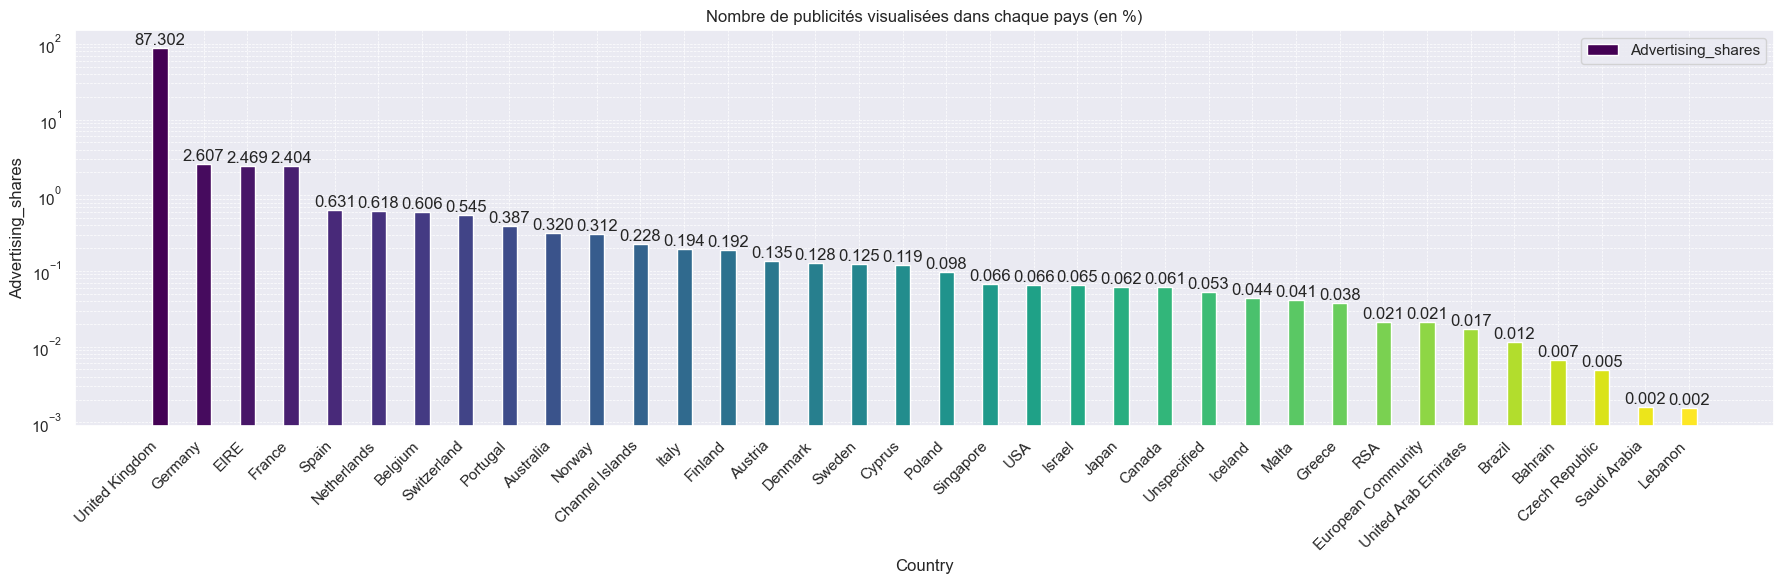

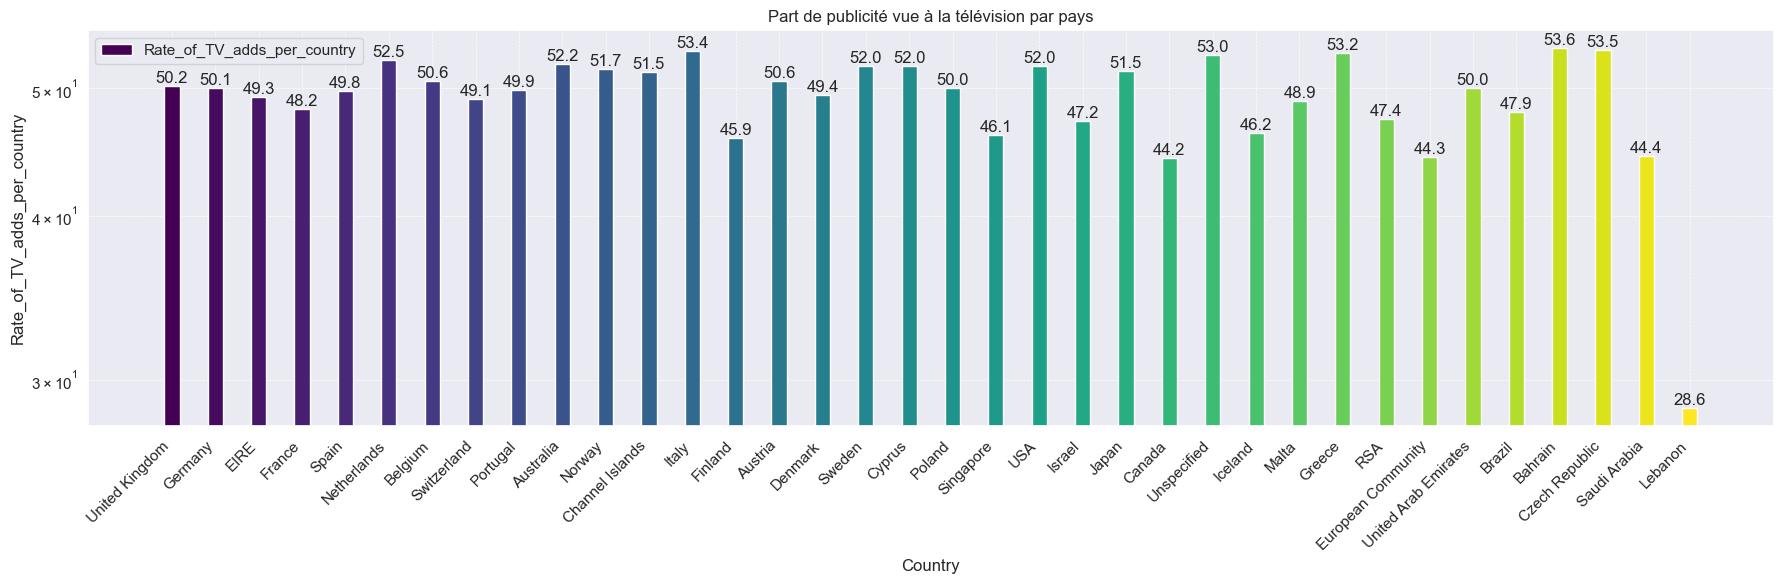

Nombre de pays ou la publicité a été majoritairement vue à la télévision : 19
Nombre de pays ou la publicité a été majoritairement vue sur internet : 18


In [44]:
# Trier les données par Nbr_Of_Diffussion
df_impressions_per_country = df_impressions_per_country.sort_values('Nbr_Impressions', ascending =False)

#Part de publicités visionnées sur le nombre total diffusé
df_impressions_per_country['Advertising_shares'] = df_impressions_per_country['Nbr_Impressions']/df_join_transaction_impression_clean.shape[0]*100
f.histogramme_baton (df_impressions_per_country, 'Country', 'Advertising_shares','Nombre de publicités visualisées dans chaque pays (en %)',3)

#Part de publicités visionnées à la TV
df_impressions_per_country['Rate_of_TV_adds_per_country'] = df_impressions_per_country['Nbr_TV_Impressions']/(df_impressions_per_country['Nbr_TV_Impressions']+df_impressions_per_country['Nbr_DISPLAY_Impressions'])*100
f.histogramme_baton (df_impressions_per_country, 'Country', 'Rate_of_TV_adds_per_country','Part de publicité vue à la télévision par pays',1)

print('Nombre de pays ou la publicité a été majoritairement vue à la télévision :', df_impressions_per_country['Country'][df_impressions_per_country['Rate_of_TV_adds_per_country']>=50].shape[0])
print('Nombre de pays ou la publicité a été majoritairement vue sur internet :', df_impressions_per_country['Country'][df_impressions_per_country['Rate_of_TV_adds_per_country']<=50].shape[0])

**Grahique 1 : Nombre de publicités visualisées dans chaque pays (en %)**

Une fois de plus, on constate que la majeure partie des publicités visionnées l'ont été au Royaume-Unis. Le pays concentre à lui seul, 87% des publicités visionnées.

**Graphique 2 : Part de publicité visionnée à la télévision par pays**

Ce graphique permet de visualiser quels type de publicité a été le plus visionné dans chaque pays. On compte 19 pays dans lesquels la publicité par la télévision est plus importante et 18 pays ou la publicité par internet est majoritaire.

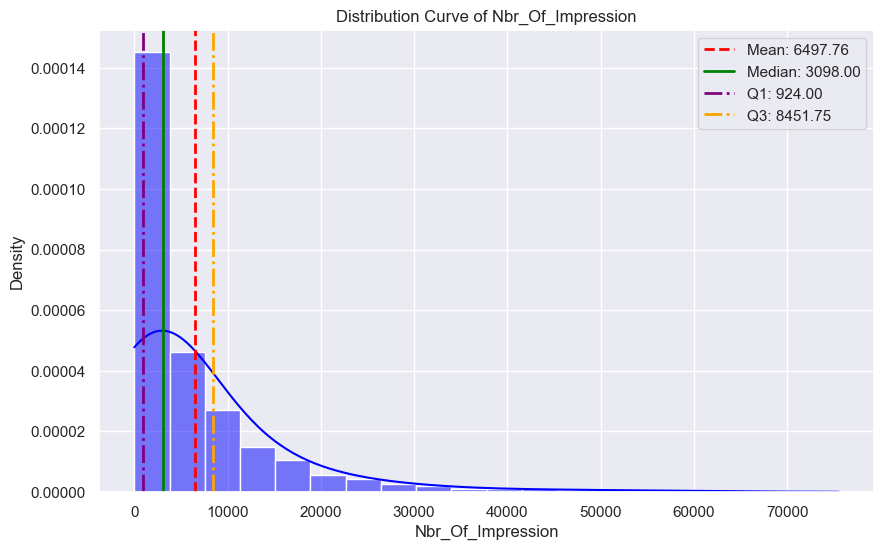

In [46]:
#Pour chaque produit, on détermine combien de fois le produit a été visualisé.
df_nbr_impressions_per_item = df_join_transaction_impression_clean.groupby('ItemId').agg(ItemDescription=('ItemDescription', 'first'),Nbr_Of_Impression=('ImpressionDate', 'count')).reset_index()

#On retire les données aberrantes
df_nbr_impressions_per_item = f.filter_aberrant_values (df_nbr_impressions_per_item, 'Nbr_Of_Impression')

# Trier par le nombre de diffusions décroissant pour obtenir le top 10
df_nbr_impressions_per_item = df_nbr_impressions_per_item.sort_values(by='Nbr_Of_Impression', ascending=False)

#On affiche la courbe de distribution
f.distribution_curve(df_nbr_impressions_per_item, 'Nbr_Of_Impression')

Ici, nous nous intéressons à savoir comment les produits ont été mis en avant indépendemment. D'après ces statistiques, un item a été visionné en moyenne 6500 fois. Néanmois, la médiane est située bien à gauche de la moyenne : 50% des items ont bénéficié d'une visibilité de moins de 3100 visualisations pas des consommateurs et 50% davantage.

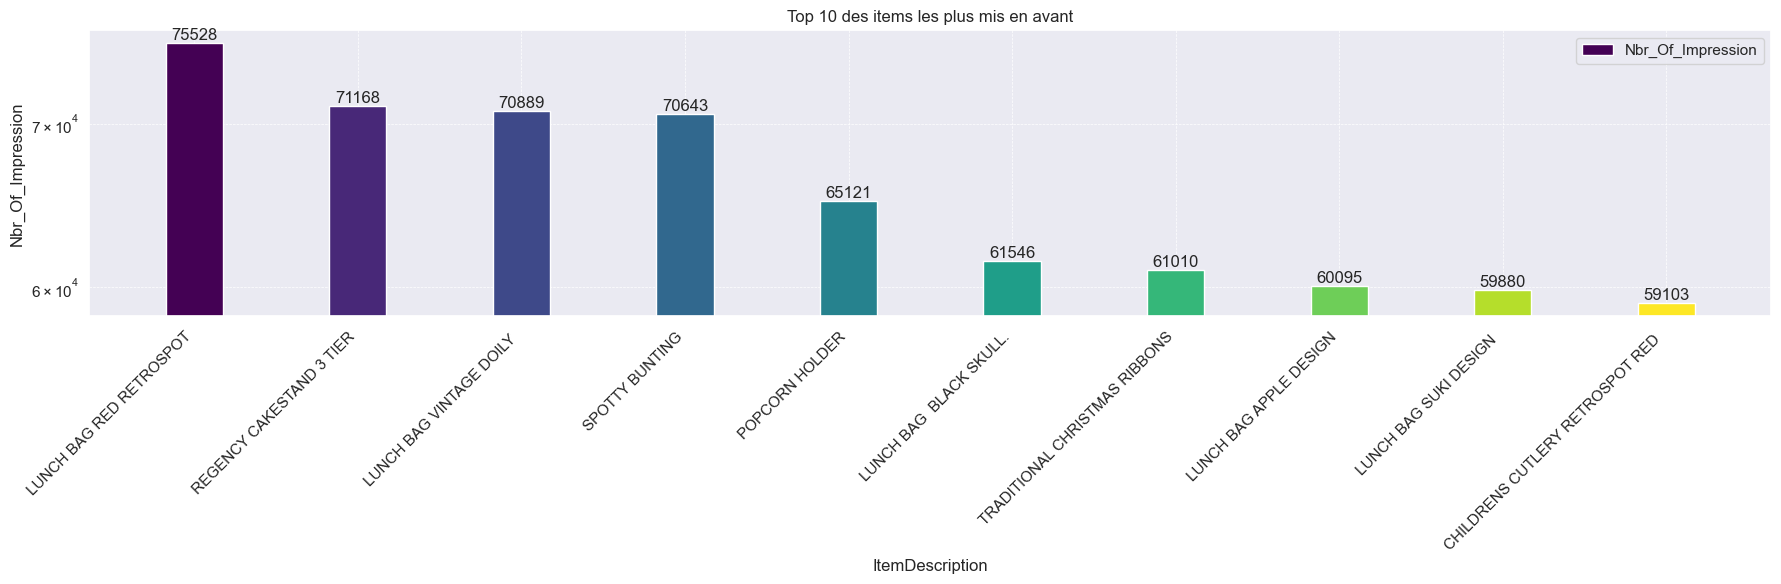

In [47]:
#Top 10 des articles les plus visionnés
df_graphique = df_nbr_impressions_per_item[:10]

f.histogramme_baton (df_graphique, 'ItemDescription', 'Nbr_Of_Impression','Top 10 des items les plus mis en avant',0)

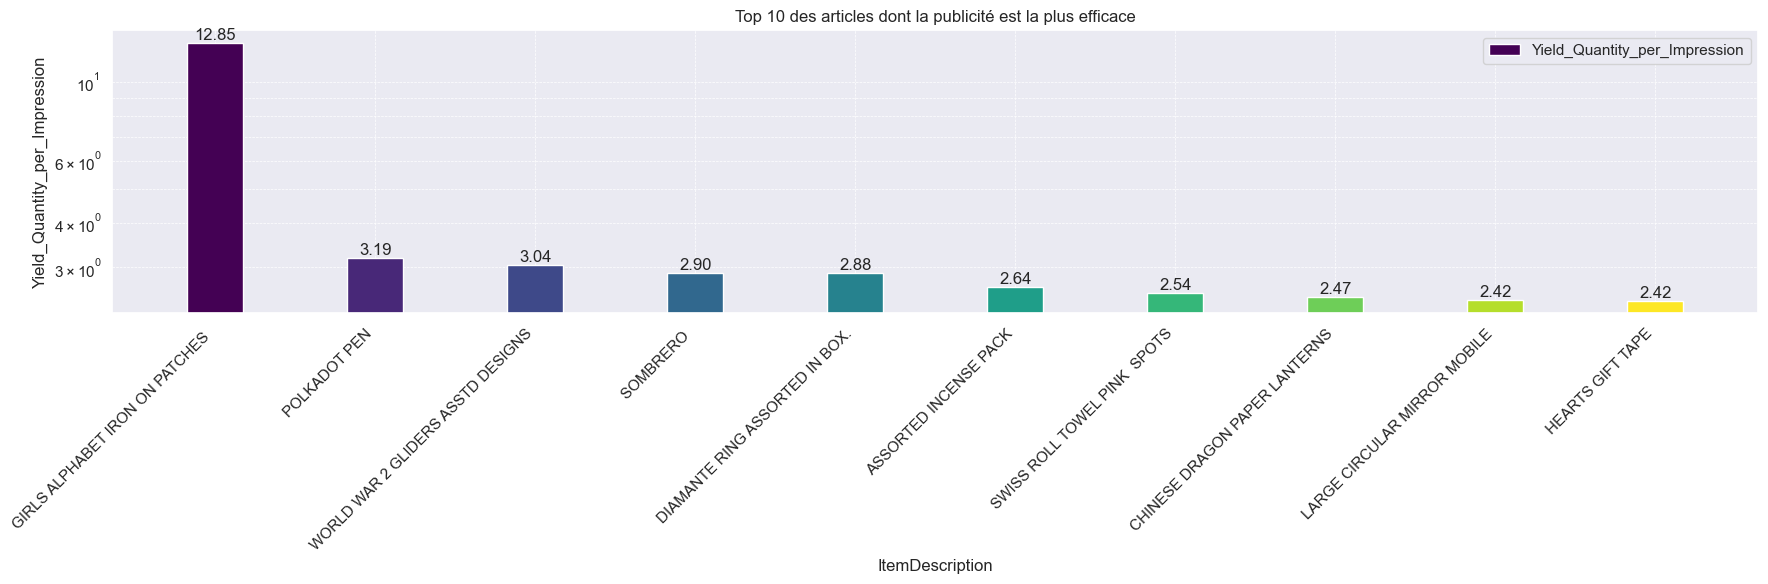

In [48]:
#En reprenant le dataframe précédent df_nbr_sales_per_item, nous allons pouvoir évaluer quels ont été les produits avec le meilleur rendement d'achat par publicité.

#On réalise une jointure entre df_nbr_sales_per_item et df_nbr_sales_per_item selon l'ItemId
df_yield_transaction_per_impression = pd.merge(df_nbr_sales_per_item, df_nbr_impressions_per_item, left_on='ItemId', right_on='ItemId', how='left')
#Suppression de colonnes
df_yield_transaction_per_impression = df_yield_transaction_per_impression.drop(['ItemDescription_y'], axis=1)
#Renommer colonne
df_yield_transaction_per_impression = df_yield_transaction_per_impression.rename(columns={'ItemDescription_x': 'ItemDescription'})

#On calcule le ratio d'article vendus par publicités diffusées
df_yield_transaction_per_impression['Yield_Quantity_per_Impression'] = df_yield_transaction_per_impression['Total_quantity_sold']/df_yield_transaction_per_impression['Nbr_Of_Impression']

#Quelques articles n'ont pas été du tout diffusé, on ne les retient donc pas
df_yield_transaction_per_impression = df_yield_transaction_per_impression.dropna()

#Afin que les statistiques soient pertinentes, nous allons considérer uniquement les articles qui ont été diffusés au moins 914 fois (correspond au 1er quartile)
df_yield_transaction_per_impression = df_yield_transaction_per_impression[df_yield_transaction_per_impression['Nbr_Of_Impression']>=914]

#On trie par Yield_Quantity_per_Impression
df_yield_transaction_per_impression = df_yield_transaction_per_impression.sort_values(by='Yield_Quantity_per_Impression', ascending = False)

#Top 10 des articles dont la publicité est la plus efficace
df_graphique = df_yield_transaction_per_impression[:10]

f.histogramme_baton (df_graphique, 'ItemDescription', 'Yield_Quantity_per_Impression','Top 10 des articles dont la publicité est la plus efficace',2)

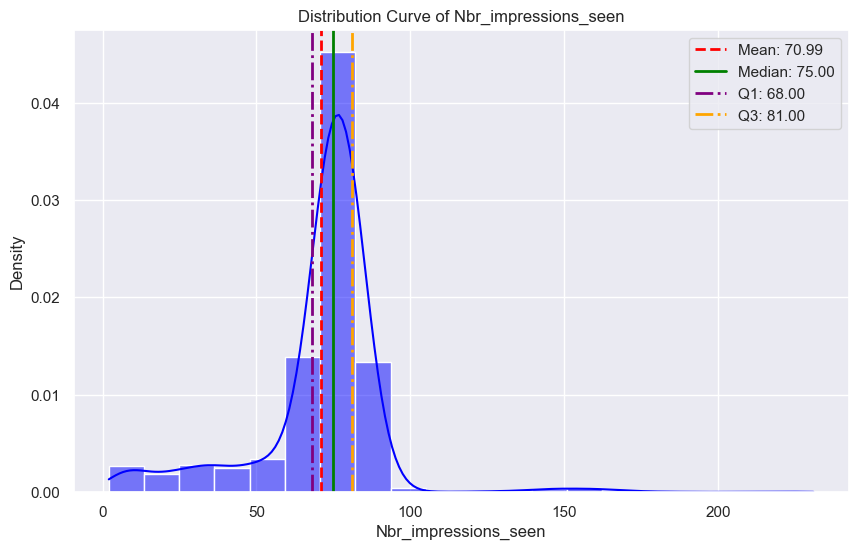

In [50]:
#Pour chaque produit, on détermine combien de fois le produit a été visualisé.
df_impression_seen_by_transaction = df_join_transaction_impression_clean.groupby(['TransactionId','ItemId']).agg(ItemDescription=('ItemDescription', 'first'),Nbr_impressions_seen=('ImpressionDate', 'count')).reset_index()

#On retire les données aberrantes
df_impression_seen_by_transaction = f.filter_aberrant_values (df_impression_seen_by_transaction, 'Nbr_impressions_seen')

# Trier par le nombre de diffusions décroissant pour obtenir le top 10
df_impression_seen_by_transaction = df_impression_seen_by_transaction.sort_values(by='Nbr_impressions_seen', ascending=False)

#On affiche la courbe de distribution
f.distribution_curve(df_impression_seen_by_transaction, 'Nbr_impressions_seen')

On constate donc qu'il faut en moyenne 71 visionnages de publicités avant qu'un utilisateur réalise l'achat d'un Item.

On s'intéresse à savoir si un type de publicité est plus propice pour déclencher un achat. Pour cela, nous allons étudier quel type de publicité a été le dernier visionné avant une transaction pour chaque article. 

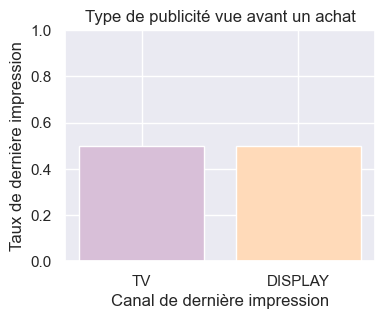

Rate_last_impressions_Seen_is_TV =  0.5
Rate_last_impressions_Seen_is_DISPLAY =  0.5


In [51]:
df_join_transaction_impression_clean['ImpressionDate'] = pd.to_datetime(df_join_transaction_impression_clean['ImpressionDate'], errors='coerce')

list_last_channel_seen=[]

#On récupère la date de la dernière impression avant une transaction
for transactionId in df_join_transaction_impression_clean['TransactionId'].unique():
    index_last_impression_seen = df_join_transaction_impression_clean[df_join_transaction_impression_clean['TransactionId'] == transactionId]['ImpressionDate'].idxmax()
    # Ajoutez la valeur de 'Channel' correspondant à cet index à la liste
    list_last_channel_seen.append(df_join_transaction_impression_clean.loc[index_last_impression_seen, 'Channel'])

total_last_impressions_Seen = len(list_last_channel_seen)
Rate_last_impressions_Seen_is_TV = list_last_channel_seen.count('TV')/total_last_impressions_Seen 
Rate_last_impressions_Seen_is_DISPLAY = list_last_channel_seen.count('DISPLAY')/total_last_impressions_Seen 


# Données à afficher
rates = [Rate_last_impressions_Seen_is_TV, Rate_last_impressions_Seen_is_DISPLAY]
labels = ['TV', 'DISPLAY']

# Création de l'histogramme à barres
plt.figure(figsize=(4, 3))
plt.bar(labels, rates, color=['#d8bfd8', '#ffdab9'])

# Ajout de titres et de labels
plt.title('Type de publicité vue avant un achat')
plt.xlabel('Canal de dernière impression')
plt.ylabel('Taux de dernière impression')
plt.ylim(0, 1)  # Limite l'axe y de 0 à 1

# Affichage
plt.show()
print('Rate_last_impressions_Seen_is_TV = ', round(Rate_last_impressions_Seen_is_TV,2))
print('Rate_last_impressions_Seen_is_DISPLAY = ', round(Rate_last_impressions_Seen_is_DISPLAY,2))

Il ne semble pas y avoir un type de publicité qui soit meilleur pour déclander un achat. 